# Exercise 1.7.1 — Scene Understanding
## Part 2: Object Detection
#### By Jonathan L. Moran (jonathan.moran107@gmail.com)
From the Self-Driving Car Engineer Nanodegree programme offered at Udacity.

## Objectives

* Use the [TensorFlow Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection) to perform object detection;
* Find and implement a pre-trained model from the [TensorFlow Detection Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md);
* Evaluate the results of the detection net on a test set;

## 1. Introduction

In [1]:
### Importing required modules

In [34]:
import numpy as np
import os
import tensorflow as tf
from typing import Callable, List, Union, Tuple

In [3]:
tf.__version__

'2.11.0'

In [4]:
tf.test.gpu_device_name()

''

In [5]:
### Setting the environment variables

In [6]:
ENV_COLAB = True                # True if running in Google Colab instance

In [7]:
# Root directory
DIR_BASE = '' if not ENV_COLAB else '/content/'

In [8]:
# Subdirectory to save output files
DIR_OUT = os.path.join(DIR_BASE, 'out/')
# Subdirectory pointing to input data
DIR_SRC = os.path.join(DIR_BASE, 'data/')

In [9]:
### Creating subdirectories (if not exists)
os.makedirs(DIR_OUT, exist_ok=True)

### 1.3. Convolutional Network Architectures

#### FCN-8 

The [FCN-8]() architecture by Long et al., 2014 [2] is an architecture that uses $1\times 1$ convolutional layers to replace the fully-connecte—d layers of a standard neural network. As a result, the FCN-8 architecture is able to preserve spatial information of the input tensor and perform the down-sampling and feature extraction routines of a convolutional network.

Fully-Convolutional Network (FCN) architectures have two primary components — an _encoder_ and a _decoder_. The encoder extracts features from an image using a series of sliding window convolution operations. The decoder in an FCN is used to up-scale the down-sampled intermediate feature maps generated from the encoder to a higher resolution — usually matching the original input dimensions. In the FCN-8 architecture, the encoder block is a set of $1\times 1$ convolution layers. The decoder block of the FCN-8 is a set of transposed convolution layers which upsample the feature maps to the size of the original input. This process is usually referred to as "reverse convolution" or deconvolution since its effect is essentially reversing (with some loss) the downsampling of the input. 

In order to preserve fine-grained segmentation maps through the network to the decoder block, a set of skip _connections_ are used. Essentially, these "connections" between non-adjacent layers of differing resolutions help retain information from the original input by combining the output feature maps of each respective layer using an element-wise addition operation. As a result, the FCN-8 with skip connections is able to use information from multiple resolutions to make more precise segmentation decisions. Skip connections, along with the other advancements from the FCN-8 architecture, have proven successful in empirical studies between the FCN-8 and its "sister" networks — the FCN-16 and FCN-32. For more information on Fully-Convolutional Networks, see the [notebook from the previous lesson](https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/1.7/1-Computer-Vision/Exercises/1-6-1-Fully-Convolutional-Networks/2023-01-23-Fully-Convolutional-Networks.ipynb).  

#### MobileNets

The [MobileNets](https://arxiv.org/abs/1704.04861) architecture by Howard et al., 2017 [1] is an architecture that uses depth-wise separable convolutions to build light-weight deep neural networks. The MobileNets architecture, as the name suggests, is designed to run object detection and classification tasks efficiently (i.e., with high FPS and low memory footprint) on mobile and embedded devices. The MobileNets architecture achieves this in a three-part approach:
1. **Depth-wise separable convolutions** — Perform a depth-wise convolution followed by a $1\times 1$ convolution (instead of a standard convolution). The $1\times 1$ convolution is called a point-wise convolution if it follows after a depth-wise convolution;
2. **Width multipliers** — Reduces the size of the input / output channels using a scaling factor set to a value between $0.0$ and $1.0$;
3. **Resolution multipliers** — Reduces the size of the original input using a scaling factor set to a value between $0.0$ and $1.0$.

These three techniques reduce the cummulative number of parameters in the network and therefore the amount of computation required. The downside to models exploiting the parameter reduction approach is that accuracy is often the trade-off. 

#### Single Shot Detector (SSD)

Many of the earlier deep neural network architectures involved networks with more than one training phase; the [Faster-RCNN](https://arxiv.org/abs/1506.01497) for example, first trains a Region Proposal Network (RPN) which is then merged with a pre-trained classification sub-network. The [Single Shot Detector](https://arxiv.org/abs/1512.02325) (SSD) by Liu et al., 2015 [3] combines these two sub-networks into a single-pass network that predicts bounding box locations and classifies the corresponding object classes. The major difference with single-shot networks is that they can be trained end-to-end, whereas architectures with multiple sub-networks, such as the Faster-RCNN, must train each module separately. The following is an outline of the original SSD architecture proposed by Liu et al., 2015 [3]:

<img src="figures/2023-01-26-Figure-4-Single-Shot-Detector-Network-Architecture.png" alt="Figure 4. Architecture of the Single Shot Detector (SSD) proposed by Liu et al., 2015.">

$$
\begin{align}
\textrm{Figure 4. Architecture of the Single Shot Detector (SSD) proposed by Liu et al., 2015.}
\end{align}
$$

In the above architecture, we note the use of the VGG-16 pre-trained convolutional base. In this notebook, we will instead be using the MobileNet pre-trained base from Howard et al., 2017 [1].

##### Bounding box detection with SSD

SSD operates on feature maps to predict bounding box locations. Recall a feature map of $\mathrm{D}_{f} * \mathrm{D}_{f} * \mathrm{M}$. For each feature map location, $k$ bounding boxes are predicted. Each bounding box carries with it the following information:
* $\left(\mathrm{c}x, \mathrm{c}y, w, h\right)$ — Four bounding box corner offset locations;
* $C = \left(c_{1}, c_{2},\ldots, c_{p}\right)$ — class probabilities.

The SSD does not predict the _shape_ of the box but rather the location of where the box is in the image. The $k$ bounding boxes each have a pre-determined shape (i.e., the anchors). This is illustrated in the figure below:

<img src="figures/2023-01-26-Figure-5-Bounding-Box-Internal-Representation-with-SSD.png" alt="Figure 5. Internal representation of bounding boxes using anchors with the Single Shot Detector (SSD) network.">

$$
\begin{align}
\textrm{Figure 5. Internal representation of bounding boxes using anchors in Single Shot Detector (SSD) network.}
\end{align}
$$

The anchor boxes used in the SSD have coordinates that are manually configured prior to training. Shown in Figure 5(c) is a set of $k = 4$ anchor boxes of varying size used to isolate an object for detection.

In order to filter nonsensical bounding boxes, we use a loss function. For the final set of $N$ matched boxes, we compute the loss as:
$$
\begin{align}
L &= \frac{1}{N}\left(L_{\textrm{class}} + L_{\textrm{box}}\right),
\end{align}
$$
where $L_{\textrm{class}}$ is a softmax loss for classification, and $L_{\textrm{box}}$ is an L1 smooth loss representing the error of the matched boxes to the ground-truth boxes. Note that L1 smooth loss is a modification of the standard L1 loss which is more robust to outliers. Also note that when $N = 0$, the loss is set to $0.0$.

##### In Summary

* A pre-trained convolutional base is used (e.g., VGG-16 or MobileNet);
* The base model is extended with several convolutional blocks;
* Each feature map is used to predict bounding boxes, and therefore diversity in feature map size allows for object detection at different resolutions;
* Boxes are filtered by the Intersection over Union (IoU) metric and with hard negative mining (looking for difficult-to-detect examples);
* The loss functions are softmax for classification and smooth L1 for detection;
* The entire SSD network can be trained end-to-end.

## 2. Programming Task

### 2.3. Object Detection Inference

NOTE: the code provided here has been migrated to the TensorFlow 2.x API based on the TensorFlow 2 Object Detection API [`inference_tf2_colab.ipynb`](https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/inference_tf2_colab.ipynb) tutorial. Some functionality may differ from the original implementation.

In this section we will detect objects using an object detection model and its pre-trained weights made available at the [TensorFlow Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md). All models and weights provided by the TensorFlow team have been pre-trained on the [COCO 2017](http://cocodataset.org/) dataset. The TensorFlow team even provides documentation regarding the use of the [Zoo models on mobile devices](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/running_on_mobile_tf2.md).

Here you may experiment with any of the following pre-trained models:
* [SSD MobileNet V1 FPN 640x640](http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_11_06_2017.tar.gz);
* [RFCN ResNet101](http://download.tensorflow.org/models/object_detection/rfcn_resnet101_coco_11_06_2017.tar.gz) — DEPRECATED (archive [here](https://github.com/openvinotoolkit/open_model_zoo/tree/master/models/public/rfcn-resnet101-coco-tf));
* [Faster R-CNN Inception ResNet V2 640x640](http://download.tensorflow.org/models/object_detection/faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017.tar.gz).

Note that the above links are for the 11.6.17 versions and are intended for use with TensorFlow v1 models. Since we are instead going to be using the TensorFlow 2.x API, it's best to download these files instead from the [TensorFlow 2 Detection Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md).

#### Setting up the TensorFlow Object Detection API

In [10]:
import pathlib

In [11]:
### Clone the `tensorflow/models` repository
if "models" in pathlib.Path.cwd().parts:
    while "models" in pathlib.Path.cwd().parts:
        os.chdir('..')
elif not pathlib.Path('models').exists():
    !git clone --depth 1 https://github.com/tensorflow/models

In [12]:
### Install the TF Object Detection API
%%bash
pip install protobuf 
#!pip install protobuf-compiler 
cd models/research
protoc object_detection/protos/*.proto --python_out=.
pip install cython 
pip install pycocotools
cp object_detection/packages/tf2/setup.py .
python3 -m pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=21919980 sha256=716156fee455e0ba507b9688c656d2f760282dbd36d5a7c227d6110243a23b2b
  Stored in directory: /tmp/pip-ephem-wheel-cache-20wzve55/wheels/7d/96/c1/072a751379735e8dfdada1def1c62a89afb3cc45654fd6fd28
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:

In [13]:
### Import required Python modules
import io
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageColor, ImageDraw, ImageFont
from scipy.stats import norm
import scipy.misc
from six import BytesIO

In [14]:
### Import TensorFlow modules
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

#### Defining the utility functions

In [15]:
### From TensorFlow's `inference_tf2_colab.ipynb`
# Credit: https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/inference_tf2_colab.ipynb 

In [16]:
def load_image_into_numpy_array(
        path: str
) -> np.ndarray:
    """Loads an image from file into a NumPy `ndarray`.

    The image located at `path` is read in using the TensorFlow
    file reader. The image (assumed to be RGB) is converted from
    raw bytes into a NumPy array of unsigned 8-bit values.
    The corresponding image is then returned to be used in
    the model data ingestion stage.

    :param path: Absolute file path to the image to load.
    :returns: Image loaded into a NumPy array with shape
        (img_height, img_width, 3).
    """
    
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)
    ).astype(np.uint8)


def get_keypoint_tuples(
        eval_config
):
    """Returns the keypoint edges from the given `eval_config`.
    
    The keypoint edges parsed from the `eval_config` are stored
    in a list of tuple-formatted (start, end) keypoints

    :param eval_config: Eval config containing the keypoint edges.
    :returns: List of edge tuples.
    """
    
    tuple_list = []
    kp_list = eval_config.keypoint_edge
    for edge in kp_list:
        tuple_list.append((edge.start, edge.end))
    return tuple_list

In [17]:
### From Udacity's `CarND-Object-Detection-Lab.ipynb`
# NOTE: Modified for use with TF2.x API

In [18]:
# Set colours to assign each class 
COLOUR_LIST = sorted([c for c in ImageColor.colormap.keys()])

In [20]:
def filter_boxes(
        min_score: float, 
        boxes: np.ndarray, 
        scores: np.ndarray, 
        classes: np.ndarray
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Returns boxes with a confidence above the `min_score` threshold.
    
    :param min_score: Minimum confidence score of bounding box to allow.
    :param boxes: Set of predicted bounding boxes to threshold.
    :param scores: Corresponding set of confidence (IoU) scores.
    :param classes: Corresponding set of class labels for each bbox.
    :returns: Tuple of filtered bounding boxes and their corresponding
        IoU scores and class labels.
    """
    n = len(classes)
    idxs = []
    for i in range(n):
        if scores[i] >= min_score:
            idxs.append(i)
    filtered_boxes = boxes[idxs, ...]
    filtered_scores = scores[idxs, ...]
    filtered_classes = classes[idxs, ...]
    return filtered_boxes, filtered_scores, filtered_classes


def to_image_coords(
        boxes: np.ndarray, 
        height: int, 
        width: int
) -> np.ndarray:
    """Converts bounding box coordinates to original image coordinates.
    
    De-normalises the coordinate predictions from range [0, 1] to the
    original image range given by height x width.
    :param boxes: Set of bounding box coordinates to de-normalise.
    :param height: Height of the original image (in pixels).
    :param width: Width of the original image (in pixels).
    :returns: Set of bounding boxes with coordinates in original image frame.
    """
    
    box_coords = np.zeros_like(boxes)
    box_coords[:, 0] = boxes[:, 0] * height
    box_coords[:, 1] = boxes[:, 1] * width
    box_coords[:, 2] = boxes[:, 2] * height
    box_coords[:, 3] = boxes[:, 3] * width
    return box_coords


def draw_boxes(
        image: Image, 
        boxes: np.ndarray, 
        classes: np.ndarray, 
        thickness: int=4
):
    """Draws the bounding boxes onto the image.
    
    :param image: a `PIL.Image` instance to draw bboxes onto.
    :param boxes: Set of bounding boxes to draw onto `image`.
    :param classes: Corresponding set of class labels.
    :param thickness: Line width to use for the bounding boxes.
    """
    draw = ImageDraw.Draw(image)
    for i in range(len(boxes)):
        bot, left, top, right = boxes[i, ...]
        class_id = int(classes[i])
        color = COLOR_LIST[class_id]
        draw.line(
            [(left, top), 
             (left, bot), 
             (right, bot), 
             (right, top), 
             (left, top)
            ], 
            width=thickness, 
            fill=color
        )
        
        
def load_graph(graph_file):
    """Loads a frozen inference graph"""
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return graph

#### Loading the model weights

In [27]:
# Stores as keys the model name(s) from the TF2 Model Zoo
# with corresponding values equal to the weights filename(s) 
MODELS = {
    'ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8': 'ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8.tar.gz'
}

In [28]:
# Fetching the model name and filename of weights to use
model_name = 'ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8'
model_weights_name = MODELS[model_name]

In [23]:
# Download the checkpoint (weights) and store into local directory
DIR_WEIGHTS = os.path.join(
    'models/research/object_detection', 
    'test_data'
)
if model_name == 'ssd_mobilenet_v1_fpn_640x640':
    # Download the model checkpoint
    !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8.tar.gz
    # Untar the model checkpoint file
    !tar -xf ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8.tar.gz
    # Move the model `checkpoint` folder into `DIR_WEIGHTS`
    !mv ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data
    
elif model_name == 'faster_rcnn_inception_resnet_v2_640x640':
    raise NotImplementedError

--2023-01-31 19:08:52--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.145.128, 2a00:1450:4013:c14::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.145.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90453990 (86M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_mobilenet_v1_fp 100%[===================>]  86.26M  78.6MB/s    in 1.1s    

2023-01-31 19:08:54 (78.6 MB/s) - ‘ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [90453990/90453990]



#### Loading model configs and checkpoints

In [29]:
# Set the model `pipeline.config` file path
PATH_PIPELINE_CONFIG = os.path.join(
    'models/research/object_detection/configs/tf2',
    model_name + '.config'
)
# Set the model 'checkpoint' sub-directory path
DIR_MODEL = os.path.join(
    DIR_WEIGHTS,
    'checkpoint'
)

In [32]:
# Load the TF Object Detection API model config
configs = config_util.get_configs_from_pipeline_file(
    PATH_PIPELINE_CONFIG
)
model_config = configs['model']
# Build the model for inference mode
detection_model = model_builder.build(
    model_config=model_config,
    is_training=False    # Running pre-trained model in inference mode
)
# Restore the model checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
    model=detection_model
)
ckpt.restore(
    os.path.join(DIR_MODEL, 'ckpt-0')
).expect_partial()

In [35]:
def get_model_detection_function(
    model: tf
) -> Callable[[tf.Tensor], 
              Tuple[dict, dict, tf.Tensor]
]:
    """Creates the detection / inference loop `tf.function`."""
    
    print(type(model))
    @tf.function
    def detect_fn(image):
        '''Performs inference on the input image.'''
        images, shapes = model.preprocess(image)
        prediction_dict = model.predict(image, shapes)
        detections = model.postprocess(prediction_dict, shapes)
        return detections, prediction_dict, tf.reshape(shapes, [-1])
    return detect_fn

In [36]:
# Initialise the detection function with the pre-trained model instance
detect_fn = get_model_detection_function(detection_model)

<class 'object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch'>


#### Loading the Label Map data

In order to properly map the class labels (strings, e.g., `'pedestrian'`) to class id integers (e.g., `0`), the TensorFlow 2 Object Detection API must be provided a `label_map.pbtxt` file. [Creating this file](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html#create-label-map) can be done manually or using an [automated script](https://github.com/tensorflow/models/issues/1601#issuecomment-533659942). 

Since we are (for now) using the [`pets_example.record`](https://github.com/tensorflow/models/blob/master/research/object_detection/test_data/pets_examples.record) test data set provided in the TensorFlow [Object Detection](https://github.com/tensorflow/models/tree/master/research/object_detection) repository, we will just grab the corresponding [`pet_label_map.pbtxt`](https://github.com/tensorflow/models/blob/master/research/object_detection/data/pet_label_map.pbtxt) file.

If you are attempting to use your own dataset with the TF2 Object Detection API, [check out my notebook](https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/main/1-Computer-Vision/Exercises/1-1-3-Creating-TF-Records/2022-08-03-Creating-TF-Records.ipynb) on doing just that. There we cover creating custom Label Map files using an automated script, serialising images and labels into TensorFlow-compatible [`.tfrecord`](https://www.tensorflow.org/tutorials/load_data/tfrecord) and [`TFRecordDataset`](https://www.tensorflow.org/api_docs/python/tf/data/TFRecordDataset) data files.

In [37]:
# Set the path to the Label Map
PATH_LABEL_MAP = os.path.join(
    'models/research/object_detection',
    'data',
    'pet_label_map.pbtxt'
)
# Create the Label Map instance
label_map = label_map_util.load_labelmap(
    PATH_LABEL_MAP
)
# Extract the Label Map data
N_CLASSES = label_map_util.get_max_label_map_index(label_map)
categories = label_map_util.convert_label_map_to_categories(
    label_map=label_map,
    max_num_classes=N_CLASSES,
    use_display_name=True
)
# Get the Label Map dict
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(
    label_map,
    use_display_name=True
)
label_map_dict

{'': 37}

#### Running the inference loop 

In [38]:
# Set path to input data to run inference on
# NOTE: since we loaded the `pet_label_map.pbtxt` earlier, we should
# probably only run inference on images with dog breed classes
DIR_DATA = 'models/research/object_detection/test_images'

In [39]:
# Get the first input image to load in as a NumPy array
# Can alternatively load a TFRecord file and skip NumPy conversion
# e.g., `.../test_data/pets_example.record`
img_np = load_image_into_numpy_array(
    os.path.join(DIR_DATA, 
                 'image1.jpg'  # Image with TPs (i.e., dogs to classify)
    )
)
# Convert the NumPy array to TensorFlow `tf.Tensor`
img_tensor = tf.convert_to_tensor(
    np.expand_dims(img_np, 0),
    dtype=tf.float32
)

In [40]:
# Run inference over input image
detections, predictions_dict, shapes = detect_fn(img_tensor)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [41]:
# Create a copy of the original image (for modification)
img_np_with_detections = img_np.copy()

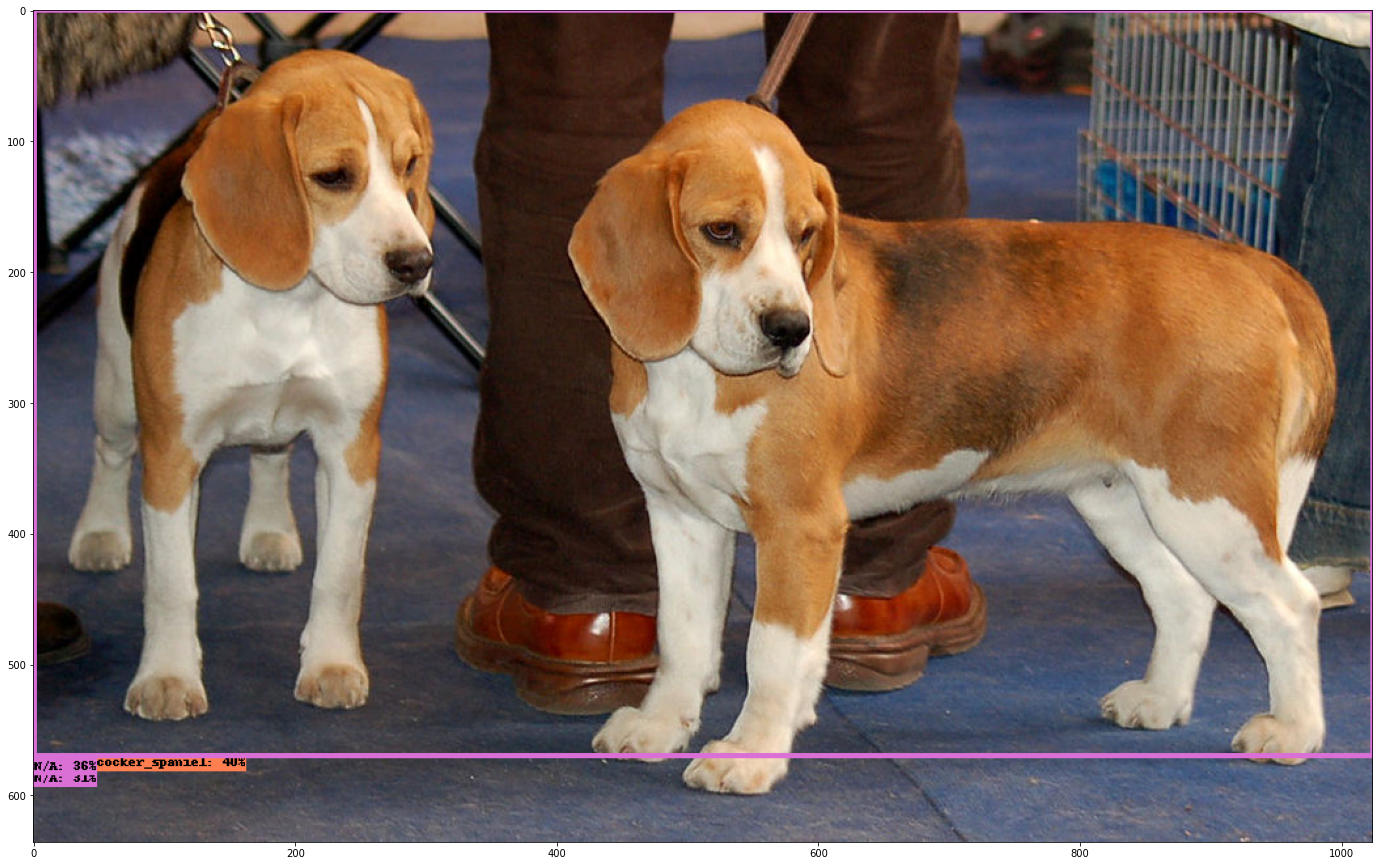

In [49]:
# Visualise the predicted bounding box(es) and class label(s)
LABEL_ID_OFFSET = 1    # Index which the label map class ids start at
viz_utils.visualize_boxes_and_labels_on_image_array(
    image=img_np_with_detections,
    boxes=detections['detection_boxes'][0].numpy(),
    classes=(detections['detection_classes'][0].numpy() 
             + LABEL_ID_OFFSET).astype(int),
    scores=detections['detection_scores'][0].numpy(),
    category_index=category_index,
    #keypoints=None,
    #keypoint_scores=None,
    #track_ids=None, 
    use_normalized_coordinates=True,
    max_boxes_to_draw=200,
    min_score_thresh=0.30,
    agnostic_mode=False,
)
plt.figure(figsize=(24, 20))
plt.imshow(img_np_with_detections)
plt.show()

With the above utility function provided by TensorFlow, we no longer need to define our own IoU thresholding or coordinate conversion / de-normalisation functions.

### 2.4. Timing Detection

### 2.5. Object Detection Pipeline

## 3. Closing Remarks

##### Alternatives
* TODO.
##### Extensions of task
* TODO.

## 4. Future Work

- ⬜️ TODO.

## Credits

This assignment was prepared by Kelvin Lwin, Andrew Bauman, Dominique Luna et al., 2021 (link [here](https://github.com/udacity/CarND-Object-Detection-Lab)).

References
* [1] Howard, A. G. et al. MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications. arXiv. 2017. [doi:10.48550/arXiv.1704.04861](https://arxiv.org/abs/1704.04861).
* [2] Shelhamer, E. et al. Fully Convolutional Networks for Semantic Segmentation. arXiv. 2016. [doi:10.48550/arXiv.1605.06211](https://arxiv.org/abs/1605.06211).
* [3] Liu, W. et al. SSD: Single Shot MultiBox Detector. European Conference on Computer Vision, ECCV. Lecture Notes in Computer Science, 9905:21-37. 2016. [doi:10.1007/978-3-319-46448-0_2](https://doi.org/10.1007/978-3-319-46448-0_2).

Helpful resources:
* [`CarND-Object-Detection-Lab` by @udacity | GitHub](https://github.com/udacity/CarND-Object-Detection-Lab);
* [3.4. Depthwise Convolution | Dive Into Deep Learning](https://tvm.d2l.ai/chapter_common_operators/depthwise_conv.html);
* [Depth-wise Convolution and Depth-wise Separable Convolution by A. Pandey | Medium](https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec);
* [Pointwise Convolution by A. Shrivastav | OpenGenus](https://iq.opengenus.org/pointwise-convolution/);
* [Depthwise Separable Convolution - A FASTER CONVOLUTION! | YouTube](https://www.youtube.com/watch?v=T7o3xvJLuHk)